In [38]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/char_transformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import time

# local imports
import models.swiglu_spe as swiglu_spe
import models.swiglu_rope as swiglu_rope
import util.generation as generation

In [19]:
key = jax.random.key(0)

# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [20]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [21]:
def create_train_state(
    model_cls,
    *,
    rng=jax.random.key(0),
    vocab_size=27,
    d_model=64,
    n_layers=3,
    n_heads=8,
    max_len=128,
    mlp_ratio=8/3
):
    """Initialize a decoder-only Transformer model and return (model, params).

    Args:
        model_cls: The Flax Module class, e.g. DecoderOnlyTransformer.
        rng: PRNGKey for parameter initialization.
        vocab_size: Vocabulary size.
        d_model: Model hidden width.
        n_layers: Number of decoder blocks.
        n_heads: Attention heads.
        max_len: Maximum sequence length.

    Returns:
        model: Instantiated Flax module.
        params: Initialized parameters dictionary.
    """

    # 1. Instantiate the model
    model = model_cls(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        max_len=max_len,
        tie_weights=False,   # weight tying enabled by default
        mlp_ratio=mlp_ratio
    )

    # 2. Dummy input for shape inference
    dummy_len = min(16, max_len)
    dummy_input = jnp.zeros((1, dummy_len), dtype=jnp.int32)

    # 3. Initialize parameters (always deterministic=True)
    params = model.init(
        {"params": rng},
        dummy_input,
        deterministic=True,
    )["params"]

    return model, params

In [22]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [23]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    # flat_logits = logits[:,-1, :]
    # flat_targets = targets[:,-1]
    # else:
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [24]:
# create an update function
def train_step(params, opt_state, x, y, rng, tx, model):
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))

In [25]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [26]:
# Create the optimizer
def create_optimizer(lr, params):
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    return tx, opt_state

In [27]:
def train(model, params, rng=jax.random.key(0), lr=0.00025, B=128, T=32, niter=100_000):
    tx, opt_state = create_optimizer(lr, params)
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, rng, tx, model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, 32
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = None
            test_logits = model.apply({"params": params}, test_input, deterministic=True)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            if it % (niter // 10) == 0 or it == niter - 1:
                print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
                print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
                print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
                print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
                print()
    return loss_history, time_history, loss_test_history, time_test_history


In [28]:
# Model Parameters
vocab_size= len(char_set)
d_model=128
n_heads=8
n_layers=3
max_len=128

swiglu_spe_model, swiglu_spe_model_params = create_train_state(
    swiglu_spe.DecoderOnlyTransformer,
    rng=key,
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    max_len=max_len,
    mlp_ratio=8/3
)

print(f"swiglu_rope_model_param_count: {count_params(swiglu_spe_model_params):_}")


swiglu_rope_model_param_count: 600_574


In [29]:
swiglu_rope_model, swiglu_rope_model_params = create_train_state(
    swiglu_rope.DecoderOnlyTransformer,
    rng=key,
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    max_len=max_len,
    mlp_ratio=8/3
)

print(f"swiglu_rope_model_param_count: {count_params(swiglu_rope_model_params):_}")


swiglu_rope_model_param_count: 600_574


In [32]:
swiglu_spe_lr=0.005
swiglu_spe_B=256
swiglu_spe_T=32
swiglu_spe_niter=100_000

swiglu_spe_loss_hist, swiglu_spe_time_hist, swiglu_spe_loss_test_hist, swiglu_spe_time_test_hist = train(
    swiglu_spe_model,
    swiglu_spe_model_params,
    key,
    swiglu_spe_lr,
    swiglu_spe_B,
    swiglu_spe_T,
    swiglu_spe_niter
)

iteration 0  time: 6.9 seconds
	 	 loss(train :: test): 3.8011 :: 3.6575
	 	 accuracy (train :: test): 3.8% :: 16.9%
	 	 accuracy (last character) (train :: test): 0.4% :: 16.8%

iteration 10_000  time: 37.4 seconds
	 	 loss(train :: test): 1.3679 :: 1.3707
	 	 accuracy (train :: test): 56.9% :: 57.2%
	 	 accuracy (last character) (train :: test): 62.5% :: 59.8%

iteration 20_000  time: 61.3 seconds
	 	 loss(train :: test): 1.3445 :: 1.3452
	 	 accuracy (train :: test): 57.8% :: 57.6%
	 	 accuracy (last character) (train :: test): 58.2% :: 58.8%

iteration 30_000  time: 84.1 seconds
	 	 loss(train :: test): 1.3256 :: 1.3281
	 	 accuracy (train :: test): 58.5% :: 58.5%
	 	 accuracy (last character) (train :: test): 63.7% :: 61.0%

iteration 40_000  time: 108.6 seconds
	 	 loss(train :: test): 1.3165 :: 1.3434
	 	 accuracy (train :: test): 58.7% :: 57.9%
	 	 accuracy (last character) (train :: test): 66.0% :: 59.1%

iteration 50_000  time: 133.6 seconds
	 	 loss(train :: test): 1.2933 ::

In [33]:
swiglu_rope_lr=0.005
swiglu_rope_B=256
swiglu_rope_T=32
swiglu_rope_niter=100_000

swiglu_rope_loss_hist, swiglu_rope_time_hist, swiglu_rope_loss_test_hist, swiglu_rope_time_test_hist = train(
    swiglu_rope_model,
    swiglu_rope_model_params,
    key,
    swiglu_rope_lr,
    swiglu_rope_B,
    swiglu_rope_T,
    swiglu_rope_niter
)

iteration 0  time: 7.0 seconds
	 	 loss(train :: test): 3.6185 :: 3.6055
	 	 accuracy (train :: test): 4.0% :: 17.1%
	 	 accuracy (last character) (train :: test): 4.7% :: 18.4%

iteration 10_000  time: 28.9 seconds
	 	 loss(train :: test): 0.1587 :: 0.1527
	 	 accuracy (train :: test): 95.2% :: 95.6%
	 	 accuracy (last character) (train :: test): 30.5% :: 32.0%

iteration 20_000  time: 48.2 seconds
	 	 loss(train :: test): 0.0725 :: 0.0665
	 	 accuracy (train :: test): 97.9% :: 98.0%
	 	 accuracy (last character) (train :: test): 34.8% :: 36.5%

iteration 30_000  time: 69.5 seconds
	 	 loss(train :: test): 0.0546 :: 0.0573
	 	 accuracy (train :: test): 98.3% :: 98.3%
	 	 accuracy (last character) (train :: test): 46.5% :: 44.4%

iteration 40_000  time: 90.9 seconds
	 	 loss(train :: test): 0.0532 :: 0.0557
	 	 accuracy (train :: test): 98.4% :: 98.3%
	 	 accuracy (last character) (train :: test): 49.2% :: 46.0%

iteration 50_000  time: 112.1 seconds
	 	 loss(train :: test): 0.0481 :: 

In [39]:
swiglu_train_loss = pd.read_csv('./data/swiglu_train_loss.csv')
swiglu_test_loss = pd.read_csv('./data/swiglu_test_loss.csv')

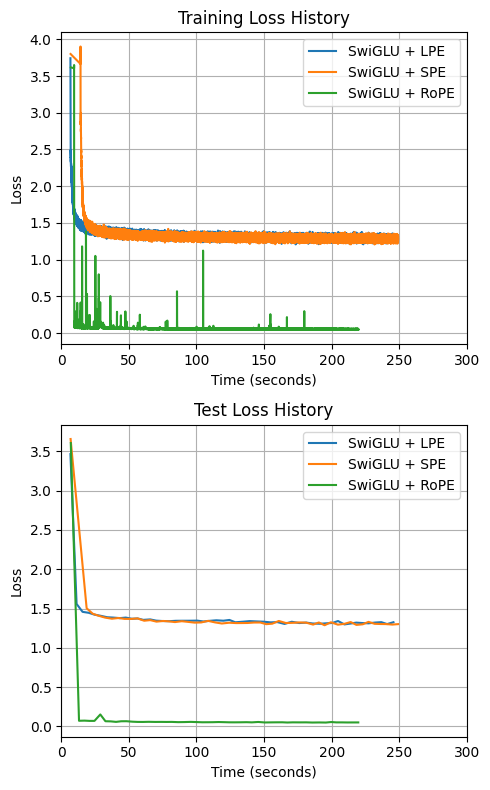

In [45]:
# plot the loss history
plt.figure(figsize=(5, 8))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(2, 1, 1)
plt.plot(swiglu_train_loss['time'], swiglu_train_loss['loss'], label="SwiGLU + LPE")
plt.plot(swiglu_spe_time_hist, swiglu_spe_loss_hist, label="SwiGLU + SPE")
plt.plot(swiglu_rope_time_hist, swiglu_rope_loss_hist, label="SwiGLU + RoPE")
plt.xlabel("Time (seconds)")
plt.xlim(0, 300)
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(2, 1, 2)
plt.plot(swiglu_test_loss['time'], swiglu_test_loss['loss'], label="SwiGLU + LPE")
plt.plot(swiglu_spe_time_test_hist, swiglu_spe_loss_test_hist, label="SwiGLU + SPE")
plt.plot(swiglu_rope_time_test_hist, swiglu_rope_loss_test_hist, label="SwiGLU + RoPE")
plt.xlabel("Time (seconds)")
plt.xlim(0, 300)
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("./assets/base_swiglu_pe_loss_history.png", dpi=300)
plt.show()

In [41]:

# Combine train and test losses if needed
swiglu_spe_train_loss = np.array([swiglu_spe_time_hist, swiglu_spe_loss_hist]).T  # shape: (iterations, 2)
swiglu_spe_test_loss = np.array([swiglu_spe_time_test_hist, swiglu_spe_loss_test_hist]).T  # shape: (iterations, 2)

# Save losses to CSV
df_loss = pd.DataFrame(swiglu_spe_train_loss, columns=['time', 'loss'])
df_loss.to_csv('./data/base_swiglu_spe_train_loss.csv', index=False)

# Save times to CSV
df_time = pd.DataFrame(swiglu_spe_test_loss, columns=['time', 'loss'])
df_time.to_csv('./data/base_swiglu_spe_test_loss.csv', index=False)

print("CSV files saved: base_swiglu_spe_train_loss.csv, base_swiglu_spe_test_loss.csv")


CSV files saved: base_swiglu_spe_train_loss.csv, base_swiglu_spe_test_loss.csv


In [42]:

# Combine train and test losses if needed
swiglu_rope_train_loss = np.array([swiglu_rope_time_hist, swiglu_rope_loss_hist]).T  # shape: (iterations, 2)
swiglu_rope_test_loss = np.array([swiglu_rope_time_test_hist, swiglu_rope_loss_test_hist]).T  # shape: (iterations, 2)

# Save losses to CSV
df_loss = pd.DataFrame(swiglu_rope_train_loss, columns=['time', 'loss'])
df_loss.to_csv('./data/base_swiglu_rope_train_loss.csv', index=False)

# Save times to CSV
df_time = pd.DataFrame(swiglu_rope_test_loss, columns=['time', 'loss'])
df_time.to_csv('./data/base_swiglu_rope_test_loss.csv', index=False)

print("CSV files saved: base_swiglu_rope_train_loss.csv, base_swiglu_rope_test_loss.csv")


CSV files saved: base_swiglu_rope_train_loss.csv, base_swiglu_rope_test_loss.csv
